In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, mergeSublistsWithSharedItems, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


Files already downloaded and verified
cuda


In [3]:

# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_normal_save/"
global_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
gmodelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
round_set.sort(reverse=True)
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

for dirpath, dirnames, filenames in os.walk(global_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        gmodelpth_set.append(os.path.join(dirpath, filename).replace("\\","/")) if "model" in filename else None

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))
print(len(gmodelpth_set))


modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 16
    weight_keys = weight_keys_resnet
else:
    assert 0==1


rounds [36, 34, 32, 30, 28, 26, 24, 22] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640
16


In [4]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")

corr_set = []
normal_nums = int(client_max)
attack_nums = int(client_max)
total_nums = normal_nums+attack_nums

for idround, round_number in enumerate(round_set):
    # if idround >= 1:
    #     break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:normal_nums] + modelpth_dict[f'{r}_attack'][0:attack_nums]
    global_model_pth = [gm for gm in gmodelpth_set if (int(re.findall(r'-?\d+', gm)[-1]) == round_number)][0]
    print(global_model_pth)
    r_corr = np.zeros((total_nums, total_nums, 1))

    fvlist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    
    g_gradient = getGradients(modelpth=global_model_pth, model=model, dataloader=Dataloader)

    for idx, modelp1 in enumerate(r_modelpth_set):
        model.load_state_dict(torch.load(modelp1))
        gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
     
    # print(gradientlist[0])
    # 定义权重键名列表
    global_grad = [g_gradient[key] for key in weight_keys]

    # 使用列表推导式创建 local_grad 和 global_grad 列表

    for id1, v in enumerate(gradientlist):
        local_grad = [v[key] for key in weight_keys]
        corrlist = []
        for id2, _ in enumerate(local_grad):
            lg = local_grad[id2].cpu().reshape((weightsize,-1))
            gg = global_grad[id2].cpu().reshape((weightsize,-1))

            l = linear_CKA(lg.T, gg.T)
            k = kernel_CKA(lg.T, gg.T)

            corrlist.append((l+k)/2)

        fvlist.append(np.array(corrlist))
        # print(fvlist[-1])

    

    for id1, v1 in enumerate(fvlist):
        if id1 >= total_nums:
            break
        for id2, v2 in enumerate(fvlist):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue
            

            r_corr[id1][id2] = np.linalg.norm(v1-v2)
    
    corr_set.append([round_number, r_corr])

print(len(corr_set))
print(corr_set[0][1].shape)
    

/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_36.pt
Files already downloaded and verified


Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_34.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_32.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_30.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_28.pt
Files already downloaded and verified


Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_26.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_24.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/attack_portion0.4_model_22.pt
Files already downloaded and verified
8
(60, 60, 1)


In [5]:
np.savetxt(f"./data/corrset_temp_{formatted_date_time}.txt",np.array([row[1] for row in corr_set]).reshape(len(corr_set), -1))

# PCODE

In [6]:
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps

36 (60, 60)


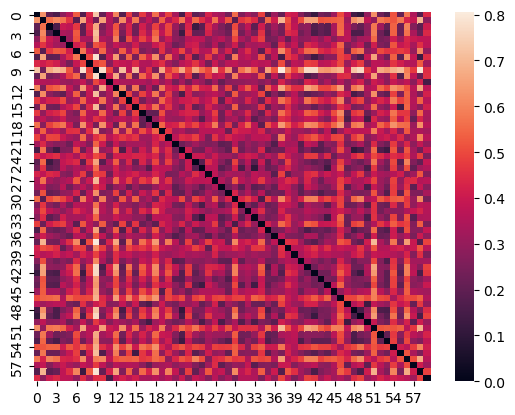

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


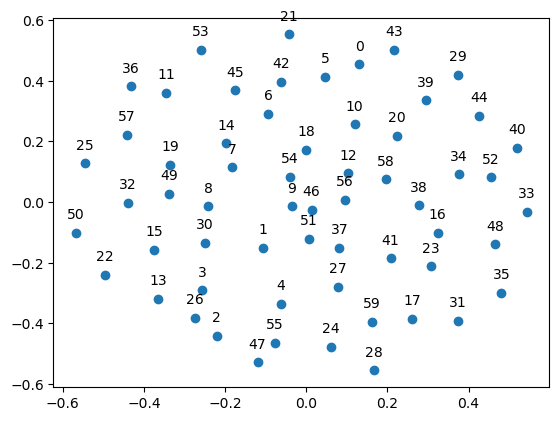

d 0 0 0.0 inf []
d 0 1 0.0 0.5161970800139459 [[9, 39]]
d 0 2 0.0 0.5096723276069843 [[37, 59]]
d 0 3 0.0 0.5076358672168234 [[9, 11]]
d 0 4 0.0 0.5071163402593799 [[46, 47]]
d 0 5 0.0 0.5046766214945526 [[28, 46]]
d 0 6 0.0 0.5007933032615477 [[46, 50]]
d 0 7 0.0 0.4981522662198151 [[56, 57]]
d 0 8 0.0 0.4977674783325997 [[9, 23]]
d 0 9 0.0 0.47932541329706524 [[26, 58]]
d 0 10 0.0 0.4785838237898081 [[9, 36]]
d 0 11 0.0 0.47129231738314104 [[8, 58]]
d 0 12 0.0 0.4585608574094797 [[9, 21]]
d 0 13 0.0 0.457263588873 [[5, 46]]
d 0 14 0.0 0.4569868631376339 [[9, 33]]
d 0 15 0.0 0.4526178821058904 [[17, 46]]
d 0 16 0.0 0.4483025713279647 [[34, 37]]
d 0 17 0.0 0.44075009993791137 [[9, 25]]
d 0 18 0.0 0.4356942343088712 [[9, 31]]
d 0 19 0.0 0.40209928311784293 [[20, 58]]
d 0 20 0.0 0.40135206050700967 [[14, 46]]
d 0 21 0.0 0.3941852223492954 [[9, 40]]
d 0 22 0.0 0.3912237669304487 [[30, 58]]
d 0 23 0.0 0.3902422742485213 [[9, 38]]
d 0 24 0.0 0.38912768592349456 [[16, 46]]
d 0 25 0.0 0.38648

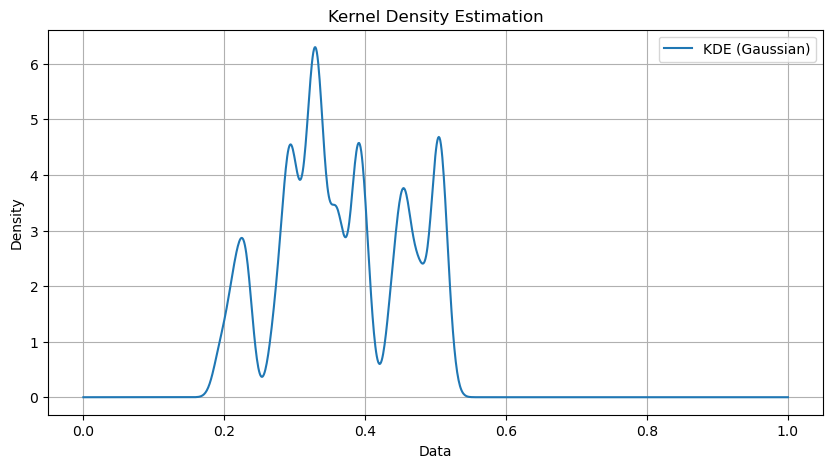

34 (60, 60)


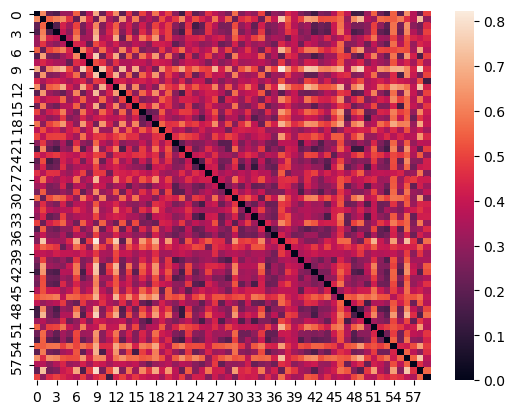

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


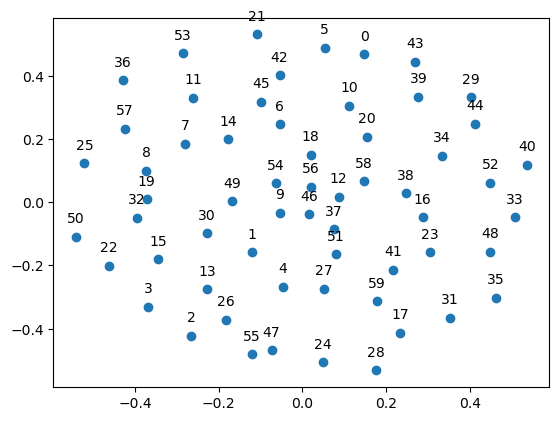

d 0 0 0.0 inf []
d 0 1 0.0 0.5098181965819628 [[9, 36]]
d 0 2 0.0 0.4927841566714015 [[12, 39]]
d 0 3 0.0 0.47713733905856226 [[11, 37]]
d 0 4 0.0 0.47532554244848446 [[8, 54]]
d 0 5 0.0 0.4629329356823506 [[28, 54]]
d 0 6 0.0 0.4625046445318597 [[31, 56]]
d 0 7 0.0 0.4552277593494046 [[56, 57]]
d 0 8 0.0 0.45084054843268717 [[23, 56]]
d 0 9 0.0 0.44532702502095245 [[21, 54]]
d 0 10 0.0 0.4423131840086798 [[46, 50]]
d 0 11 0.0 0.43735716740349373 [[37, 47]]
d 0 12 0.0 0.43310629416979873 [[25, 46]]
d 0 13 0.0 0.4300212785376485 [[37, 59]]
d 0 14 0.0 0.42829123100708455 [[5, 54]]
d 0 15 0.0 0.4178031154406533 [[26, 58]]
d 0 16 0.0 0.41244331633828335 [[33, 46]]
d 0 17 0.0 0.4090702472680452 [[9, 40]]
d 0 18 0.0 0.4090207606453986 [[17, 46]]
d 0 19 0.0 0.3967197549514322 [[9, 44]]
d 0 20 0.0 0.3871720560792906 [[9, 53]]
d 0 21 0.0 0.38314138195923153 [[9, 43]]
d 0 22 0.0 0.38226738577628006 [[9, 32]]
d 0 23 0.0 0.3819764334232991 [[34, 37]]
d 0 24 0.0 0.37772674277908647 [[9, 29]]
d 0 25

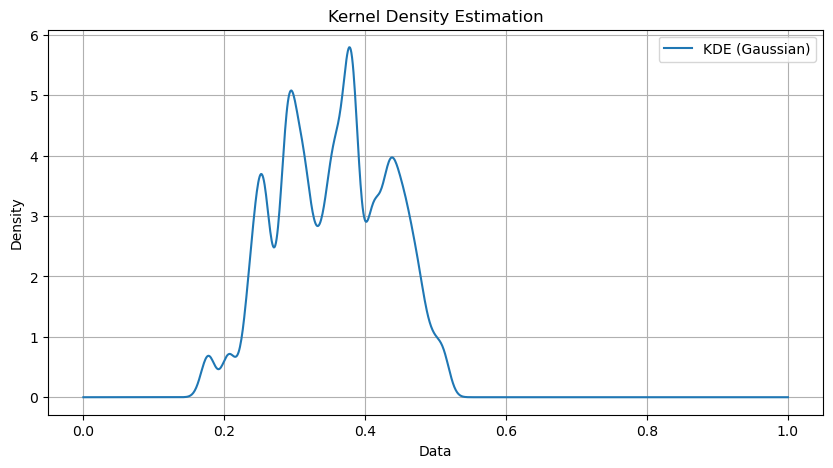

32 (60, 60)


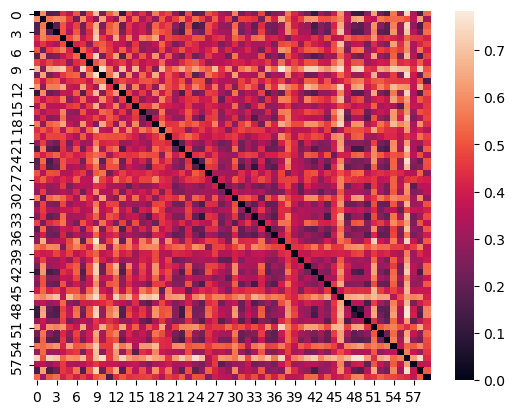

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


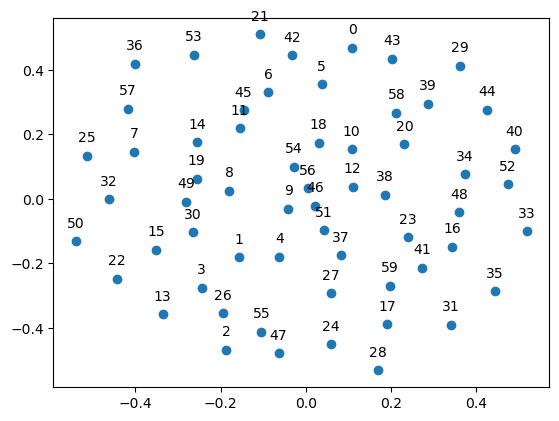

d 0 0 0.0 inf []
d 0 1 0.0 0.4507020117661149 [[10, 26]]
d 0 2 0.0 0.432483552196254 [[11, 49]]
d 0 3 0.0 0.43050393720154734 [[39, 56]]
d 0 4 0.0 0.425335168583876 [[36, 46]]
d 0 5 0.0 0.4164304175202017 [[49, 59]]
d 0 6 0.0 0.40276174208112636 [[29, 56]]
d 0 7 0.0 0.3951341082112141 [[20, 46]]
d 0 8 0.0 0.38684535255266894 [[6, 37]]
d 0 9 0.0 0.3859993337089276 [[28, 56]]
d 0 10 0.0 0.38469541798578455 [[9, 32]]
d 0 11 0.0 0.38249945330910085 [[40, 56]]
d 0 12 0.0 0.3777172705677858 [[30, 49]]
d 0 13 0.0 0.376756067616971 [[21, 46]]
d 0 14 0.0 0.37570027434344266 [[34, 56]]
d 0 15 0.0 0.37526853197905274 [[46, 50]]
d 0 16 0.0 0.37377241941176675 [[56, 57]]
d 0 17 0.0 0.3699237935216563 [[23, 56]]
d 0 18 0.0 0.35566852932859006 [[52, 56]]
d 0 19 0.0 0.35529327298474866 [[8, 46]]
d 0 20 0.0 0.35039606240612997 [[9, 43]]
d 0 21 0.0 0.3465644987064568 [[44, 56]]
d 0 22 0.0 0.34169721705007083 [[1, 37]]
d 0 23 0.0 0.3306784083236223 [[9, 38]]
d 0 24 0.0 0.33037079944816494 [[9, 15]]
d 0 2

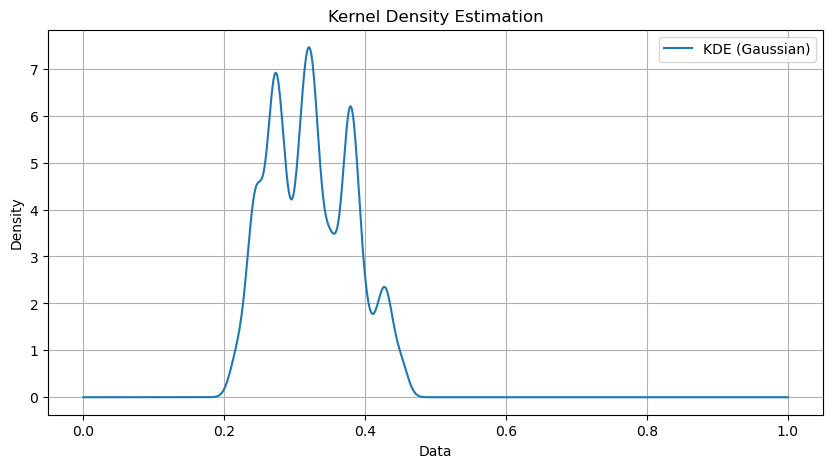

30 (60, 60)


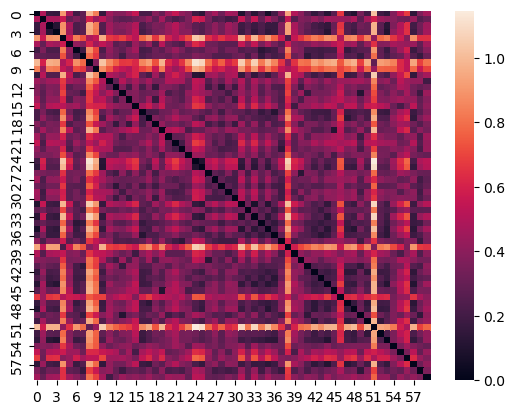

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


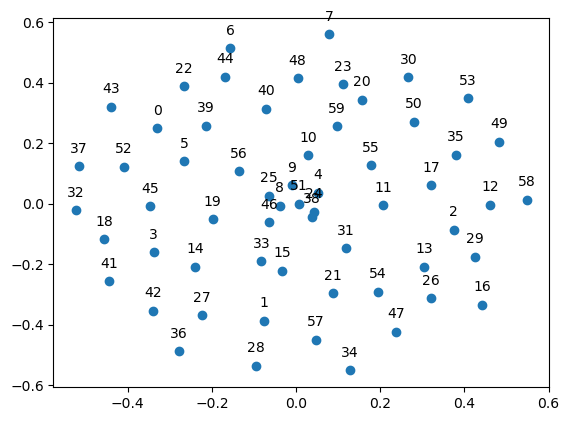

d 0 0 0.0 inf []
d 0 1 0.0 0.3960081044434455 [[1, 24]]
d 0 2 0.0 0.3903545774873176 [[29, 51]]
d 0 3 0.0 0.36326405655846883 [[24, 55]]
d 0 4 0.0 0.3599913227432483 [[20, 51]]
d 0 5 0.0 0.3586882042899011 [[8, 27]]
d 0 6 0.0 0.3564722765645366 [[5, 51]]
d 0 7 0.0 0.34891109000397913 [[8, 39]]
d 0 8 0.0 0.3440074427566008 [[8, 37]]
d 0 9 0.0 0.3352805935049129 [[15, 24]]
d 0 10 0.0 0.3255465129410633 [[8, 30]]
d 0 11 0.0 0.3234488684203318 [[21, 24]]
d 0 12 0.0 0.32338539173208647 [[14, 51]]
d 0 13 0.0 0.3188041020734216 [[22, 51]]
d 0 14 0.0 0.3078816500976006 [[51, 58]]
d 0 15 0.0 0.2862123153387083 [[13, 51]]
d 0 16 0.0 0.28157044742149595 [[49, 51]]
d 0 17 0.0 0.2586778685844159 [[18, 51]]
d 0 18 0.0 0.25264575584689897 [[24, 46]]
d 0 19 0.0 0.2332938007244829 [[28, 51]]
d 0 20 0.0 0.2289859757810334 [[12, 51]]
d 0 21 0.0 0.21756484727929104 [[24, 56]]
d 0 22 0.0 0.20788340364291125 [[8, 26]]
d 0 23 0.0 0.20464262118632404 [[7, 51]]
d 0 24 0.0 0.1921106496906213 [[8, 59]]
d 0 25 0.

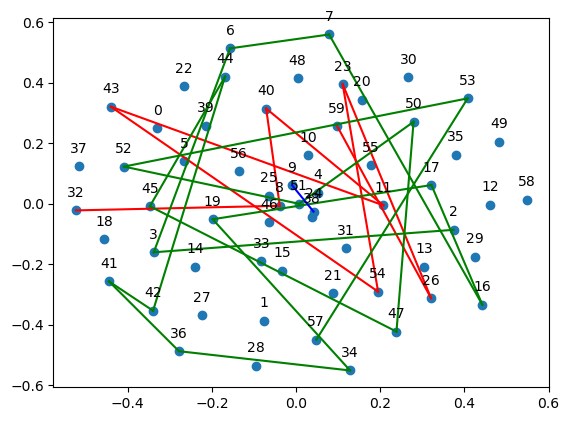

persistence =0.2289859757810334, finding: [24, 56]
 [[24, 9, 56], [32, 8, 40, 11, 43, 54, 23, 26, 59], [2, 3, 6, 7, 16, 17, 19, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57]]
merging
[[56]]
[[2, 0]]
pbow:
[array([1., 1., 0.]), array([0., 5., 3.]), array([11.,  3.,  4.])]
[[ 0.          5.09901951 10.95445115]
 [ 5.09901951  0.         11.22497216]
 [10.95445115 11.22497216  0.        ]]
score x0.5166666666666667: [0.3333333333333333] [0.5555555555555556] [0.631578947368421] 
total score : 0.8

[[24, 9, 56], [32, 8, 40, 11, 43, 54, 23, 26, 59], [2, 3, 6, 7, 16, 17, 19, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57]]


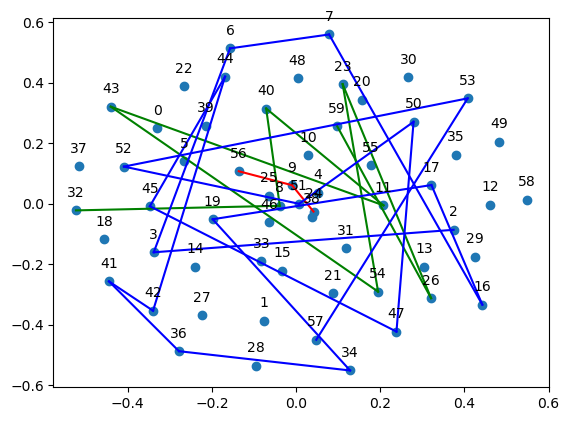

persistence =0.2332938007244829, finding: [12, 51]
 [[2, 3, 6, 7, 12, 16, 17, 19, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [24, 9, 56], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[12]]
[[2, 0]]
pbow:
[array([ 4., 11.,  4.]), array([1., 1., 0.]), array([5., 0., 3.])]
[[ 0.         11.18033989 11.09053651]
 [11.18033989  0.          5.09901951]
 [11.09053651  5.09901951  0.        ]]
score x0.5333333333333333: [0.6] [0.3333333333333333] [0.5555555555555556] 
total score : 0.7833333333333333

[[2, 3, 6, 7, 12, 16, 17, 19, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [24, 9, 56], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


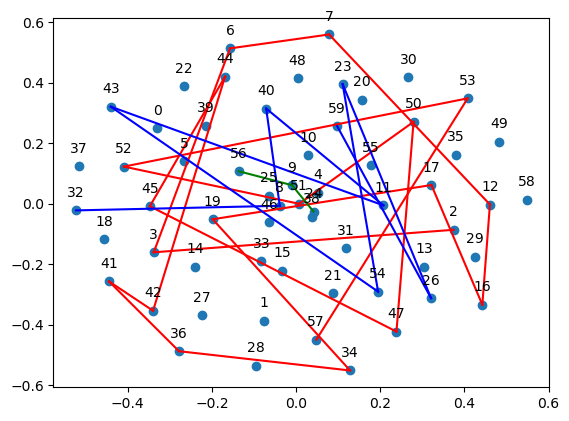

persistence =0.25264575584689897, finding: [28, 51]
 [[2, 3, 6, 7, 12, 16, 17, 19, 28, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [24, 9, 56], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[28]]
[[0, 0]]
pbow:
[array([12.,  4.,  4.]), array([1., 1., 0.]), array([0., 4., 4.])]
[[ 0.         12.08304597 12.        ]
 [12.08304597  0.          5.09901951]
 [12.          5.09901951  0.        ]]
score x0.55: [0.5714285714285714] [0.3333333333333333] [0.5555555555555556] 
total score : 0.7666666666666666

[[2, 3, 6, 7, 12, 16, 17, 19, 28, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [24, 9, 56], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


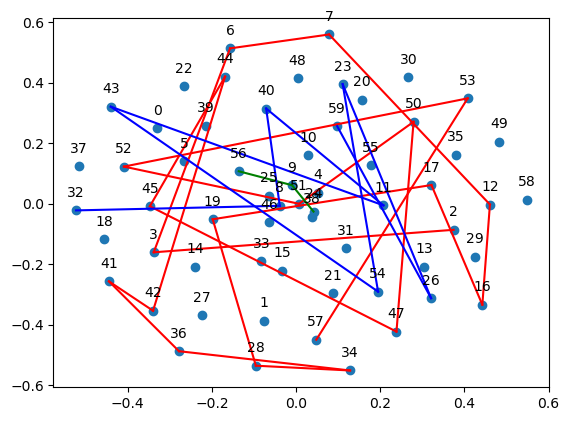

persistence =0.2586778685844159, finding: [24, 46]
 [[24, 9, 56, 46], [2, 3, 6, 7, 12, 16, 17, 19, 28, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[46]]
[[1, 0]]
pbow:
[array([0., 1., 2., 0.]), array([ 2., 11.,  3.,  4.]), array([4., 0., 1., 3.])]
[[ 0.         11.          5.19615242]
 [11.          0.         11.40175425]
 [ 5.19615242 11.40175425  0.        ]]
score x0.5666666666666667: [0.5] [0.5714285714285714] [0.5555555555555556] 
total score : 0.75

[[24, 9, 56, 46], [2, 3, 6, 7, 12, 16, 17, 19, 28, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


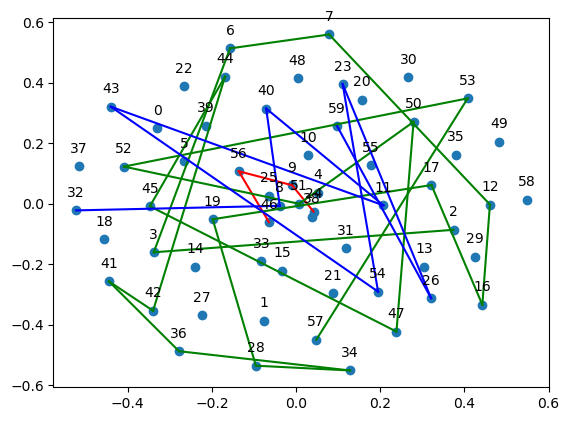

persistence =0.28157044742149595, finding: [18, 51]
 [[2, 3, 6, 7, 12, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[18]]
[[1, 0]]
pbow:
[array([11.,  3.,  4.,  3.]), array([1., 0., 0., 2.]), array([0., 5., 3., 0.])]
[[ 0.         11.22497216 11.61895004]
 [11.22497216  0.          6.244998  ]
 [11.61895004  6.244998    0.        ]]
score x0.5833333333333334: [0.5454545454545454] [0.5] [0.5555555555555556] 
total score : 0.7333333333333334

[[2, 3, 6, 7, 12, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 50, 51, 52, 53, 57], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


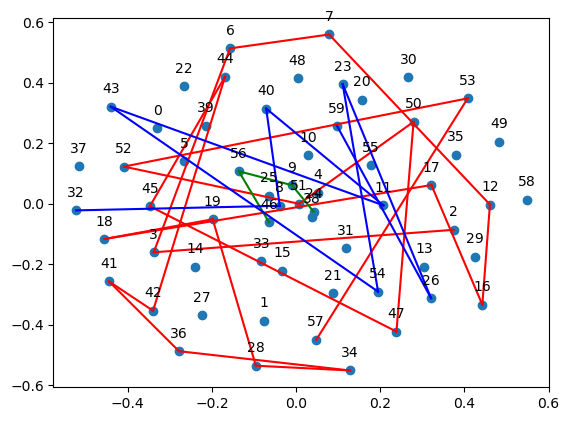

persistence =0.2862123153387083, finding: [49, 51]
 [[2, 3, 6, 7, 12, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[49]]
[[0, 0]]
pbow:
[array([11.,  4.,  4.,  3.]), array([1., 2., 0., 0.]), array([0., 0., 3., 5.])]
[[ 0.         11.35781669 11.91637529]
 [11.35781669  0.          6.244998  ]
 [11.91637529  6.244998    0.        ]]
score x0.6: [0.5652173913043478] [0.5] [0.5555555555555556] 
total score : 0.7333333333333334

[[2, 3, 6, 7, 12, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


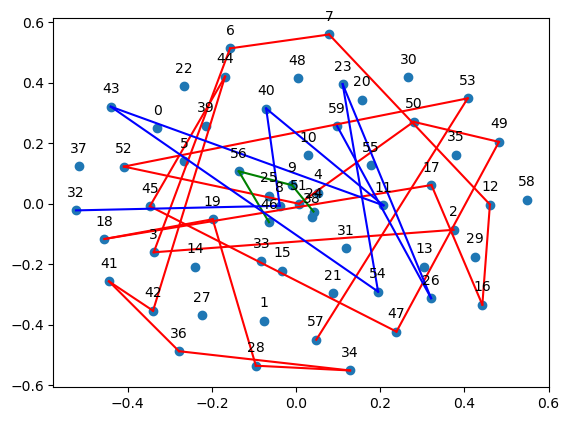

persistence =0.3078816500976006, finding: [13, 51]
 [[2, 3, 6, 7, 12, 13, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[13]]
[[0, 0]]
pbow:
[array([11.,  3.,  5.,  4.]), array([1., 1., 1., 0.]), array([0., 5., 0., 3.])]
[[ 0.         11.66190379 12.28820573]
 [11.66190379  0.          5.19615242]
 [12.28820573  5.19615242  0.        ]]
score x0.6166666666666667: [0.5416666666666666] [0.5] [0.5555555555555556] 
total score : 0.7166666666666667

[[2, 3, 6, 7, 12, 13, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


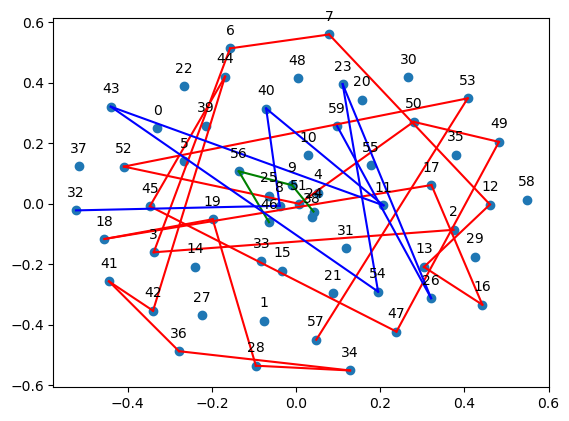

persistence =0.3188041020734216, finding: [51, 58]
 [[2, 3, 6, 7, 12, 13, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[58]]
[[0, 0]]
pbow:
[array([ 6., 11.,  4.,  3.]), array([1., 1., 0., 1.]), array([0., 0., 3., 5.])]
[[ 0.         12.04159458 12.72792206]
 [12.04159458  0.          5.19615242]
 [12.72792206  5.19615242  0.        ]]
score x0.6333333333333333: [0.56] [0.5] [0.5555555555555556] 
total score : 0.7166666666666667

[[2, 3, 6, 7, 12, 13, 16, 17, 18, 19, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


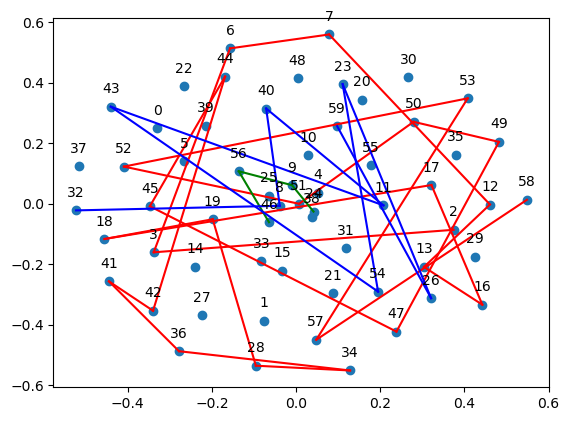

persistence =0.32338539173208647, finding: [22, 51]
 [[2, 3, 6, 7, 12, 13, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[22]]
[[0, 0]]
pbow:
[array([ 5.,  4., 11.,  5.]), array([0., 1., 1., 1.]), array([4., 4., 0., 0.])]
[[ 0.         12.24744871 12.12435565]
 [12.24744871  0.          5.19615242]
 [12.12435565  5.19615242  0.        ]]
score x0.65: [0.5384615384615384] [0.5] [0.5555555555555556] 
total score : 0.7

[[2, 3, 6, 7, 12, 13, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


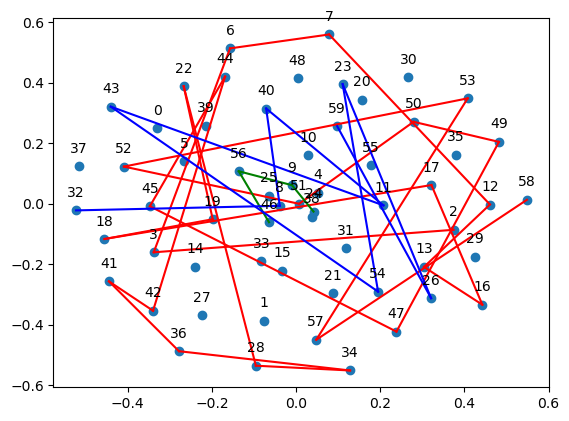

persistence =0.3234488684203318, finding: [14, 51]
 [[2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[14]]
[[0, 0]]
pbow:
[array([ 4., 11.,  6.,  5.]), array([1., 1., 1., 0.]), array([4., 0., 0., 4.])]
[[ 0.         12.60952021 12.56980509]
 [12.60952021  0.          5.19615242]
 [12.56980509  5.19615242  0.        ]]
score x0.6666666666666666: [0.5185185185185185] [0.5] [0.5555555555555556] 
total score : 0.6833333333333333

[[2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [24, 9, 56, 46], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


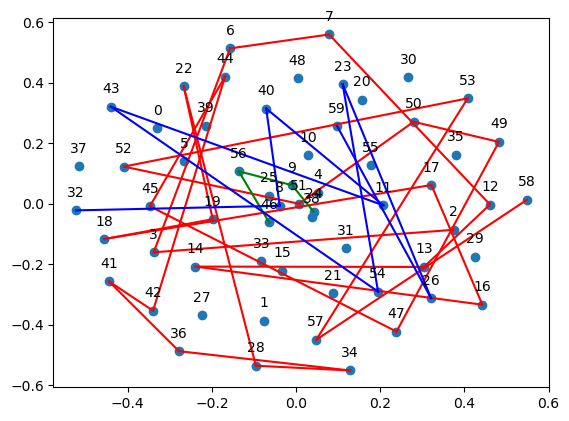

persistence =0.3255465129410633, finding: [21, 24]
 [[9, 46, 21, 24, 56], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 8, 40, 11, 43, 54, 23, 26, 59]]
merging
[[21]]
[[1, 0]]
pbow:
[array([1., 2., 0., 1., 0.]), array([11.,  4.,  2.,  5.,  4.]), array([0., 1., 4., 0., 3.])]
[[ 0.         11.83215957  5.29150262]
 [11.83215957  0.         12.64911064]
 [ 5.29150262 12.64911064  0.        ]]
score x0.6833333333333333: [0.4] [0.5185185185185185] [0.5555555555555556] 
total score : 0.6833333333333333

[[9, 46, 21, 24, 56], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 8, 40, 11, 43, 54, 23, 26, 59]]


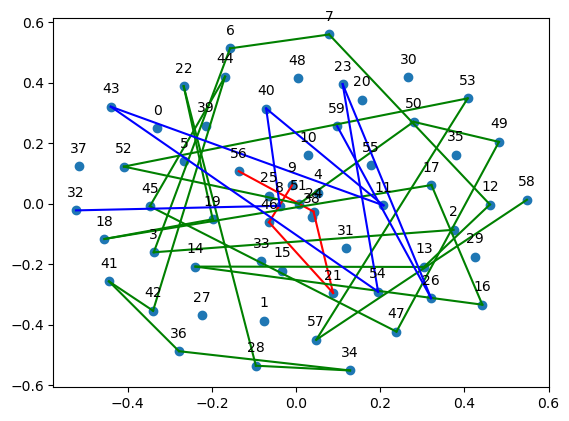

persistence =0.3352805935049129, finding: [8, 30]
 [[32, 8, 40, 11, 43, 54, 23, 26, 59, 30], [9, 46, 21, 24, 56], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]
merging
[[30]]
[[2, 0]]
pbow:
[array([3., 1., 0., 1., 4.]), array([0., 1., 1., 2., 0.]), array([ 4.,  5., 11.,  4.,  2.])]
[[ 0.          5.19615242 12.28820573]
 [ 5.19615242  0.         11.83215957]
 [12.28820573 11.83215957  0.        ]]
score x0.7: [0.6] [0.4] [0.5185185185185185] 
total score : 0.6833333333333333

[[32, 8, 40, 11, 43, 54, 23, 26, 59, 30], [9, 46, 21, 24, 56], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]


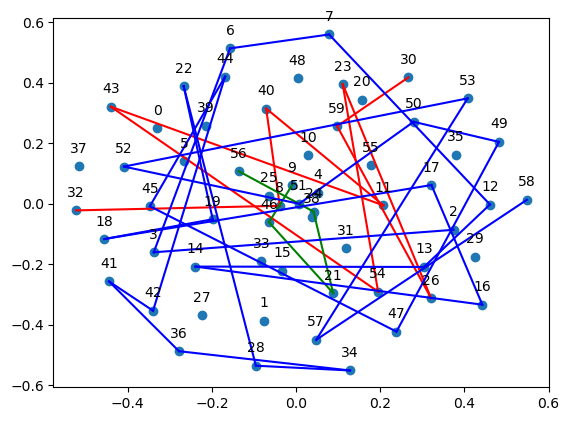

persistence =0.3440074427566008, finding: [15, 24]
 [[21, 24, 9, 56, 46, 15], [32, 8, 40, 11, 43, 54, 23, 26, 59, 30], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]
merging
[[15]]
[[1, 0]]
pbow:
[array([0., 2., 1., 2., 0.]), array([3., 1., 0., 0., 5.]), array([ 4.,  5., 11.,  3.,  3.])]
[[ 0.          6.32455532 11.61895004]
 [ 6.32455532  0.         12.28820573]
 [11.61895004 12.28820573  0.        ]]
score x0.7166666666666667: [0.3333333333333333] [0.6] [0.5185185185185185] 
total score : 0.6833333333333333

[[21, 24, 9, 56, 46, 15], [32, 8, 40, 11, 43, 54, 23, 26, 59, 30], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]


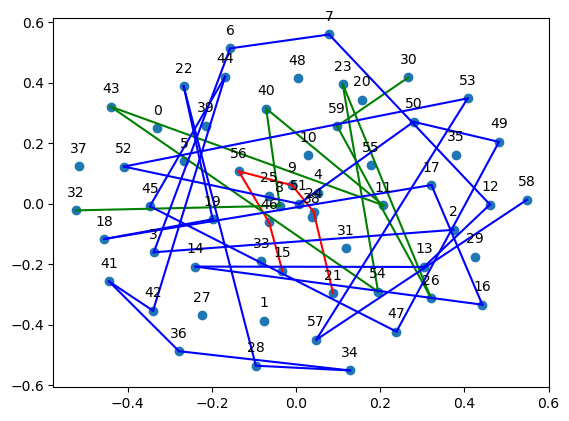

persistence =0.34891109000397913, finding: [8, 37]
 [[32, 37, 8, 40, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]
merging
[[37]]
[[1, 0]]
pbow:
[array([4., 0., 2., 1., 3.]), array([0., 1., 2., 2., 0.]), array([ 2., 11.,  5.,  4.,  4.])]
[[ 0.          5.19615242 12.        ]
 [ 5.19615242  0.         11.53256259]
 [12.         11.53256259  0.        ]]
score x0.7333333333333333: [0.6363636363636364] [0.3333333333333333] [0.5185185185185185] 
total score : 0.6833333333333333

[[32, 37, 8, 40, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]


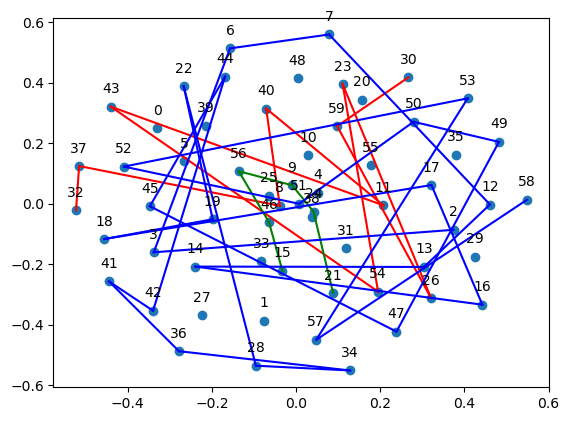

persistence =0.3564722765645366, finding: [8, 39]
 [[32, 37, 39, 8, 40, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]
merging
[[39]]
[[0, 0]]
pbow:
[array([3., 3., 0., 0., 5.]), array([2., 0., 1., 1., 1.]), array([ 3.,  4., 11.,  5.,  3.])]
[[ 0.          5.29150262 12.28820573]
 [ 5.29150262  0.         11.70469991]
 [12.28820573 11.70469991  0.        ]]
score x0.75: [0.6666666666666666] [0.3333333333333333] [0.5185185185185185] 
total score : 0.6833333333333333

[[32, 37, 39, 8, 40, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15], [2, 3, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58]]


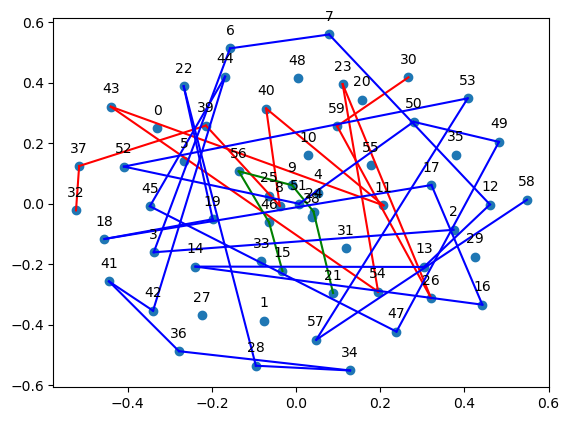

persistence =0.3586882042899011, finding: [5, 51]
 [[2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15]]
merging
[[5]]
[[2, 0]]
pbow:
[array([ 3., 12.,  4.,  5.,  3.]), array([4., 0., 3., 0., 4.]), array([1., 1., 2., 1., 0.])]
[[ 0.         13.11487705 12.40967365]
 [13.11487705  0.          5.29150262]
 [12.40967365  5.29150262  0.        ]]
score x0.7666666666666667: [0.5] [0.6666666666666666] [0.3333333333333333] 
total score : 0.6666666666666667

[[2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15]]


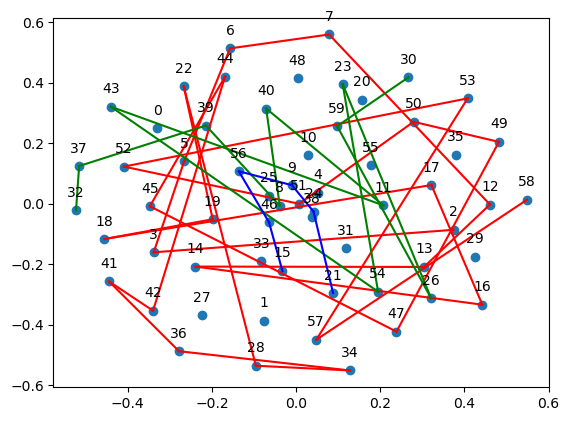

persistence =0.3599913227432483, finding: [8, 27]
 [[32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30], [2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [21, 24, 9, 56, 46, 15]]
merging
[[27]]
[[1, 0]]
pbow:
[array([0., 0., 5., 4., 3.]), array([ 5., 11.,  3.,  4.,  4.]), array([1., 1., 1., 2., 0.])]
[[ 0.         12.28820573  5.56776436]
 [12.28820573  0.         11.83215957]
 [ 5.56776436 11.83215957  0.        ]]
score x0.7833333333333333: [0.6153846153846154] [0.5] [0.3333333333333333] 
total score : 0.65

[[32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30], [2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [21, 24, 9, 56, 46, 15]]


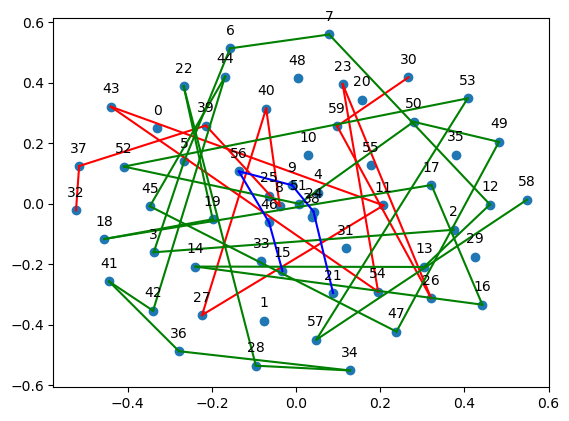

persistence =0.36326405655846883, finding: [20, 51]
 [[2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15]]
merging
[[20]]
[[1, 0]]
pbow:
[array([ 5., 11.,  3.,  4.,  5.]), array([4., 0., 5., 3., 0.]), array([2., 1., 1., 0., 1.])]
[[ 0.         12.32882801 12.04159458]
 [12.32882801  0.          5.56776436]
 [12.04159458  5.56776436  0.        ]]
score x0.8: [0.4827586206896552] [0.6153846153846154] [0.3333333333333333] 
total score : 0.65

[[2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30], [21, 24, 9, 56, 46, 15]]


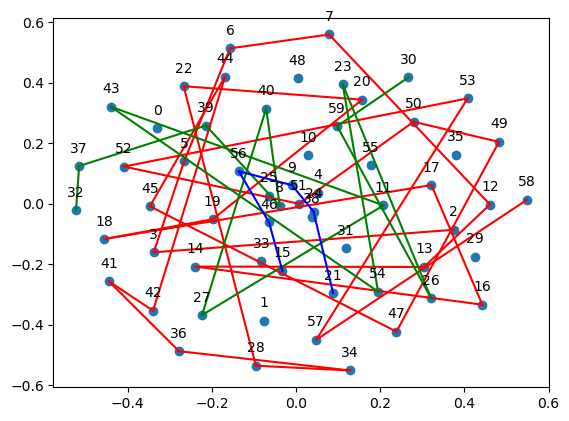

persistence =0.3903545774873176, finding: [24, 55]
 [[21, 55, 24, 9, 56, 46, 15], [2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30]]
merging
[[55]]
[[2, 0]]
pbow:
[array([1., 3., 1., 1., 0.]), array([ 3.,  5., 11.,  5.,  4.]), array([5., 4., 0., 0., 3.])]
[[ 0.         11.83215957  5.29150262]
 [11.83215957  0.         12.32882801]
 [ 5.29150262 12.32882801  0.        ]]
score x0.8166666666666667: [0.42857142857142855] [0.4827586206896552] [0.6153846153846154] 
total score : 0.6333333333333333

[[21, 55, 24, 9, 56, 46, 15], [2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30]]


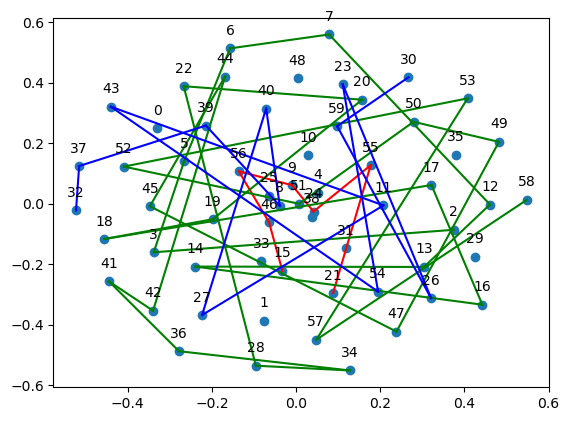

persistence =0.3960081044434455, finding: [29, 51]
 [[2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 29, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [21, 55, 24, 9, 56, 46, 15], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30]]
merging
[[29]]
[[1, 0]]
pbow:
[array([ 3., 11.,  6.,  5.,  4.]), array([1., 1., 3., 1., 0.]), array([5., 0., 4., 0., 3.])]
[[ 0.         12.04159458 12.4498996 ]
 [12.04159458  0.          5.29150262]
 [12.4498996   5.29150262  0.        ]]
score x0.8333333333333334: [0.4666666666666667] [0.42857142857142855] [0.6153846153846154] 
total score : 0.6333333333333333

[[2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 29, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [21, 55, 24, 9, 56, 46, 15], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30]]


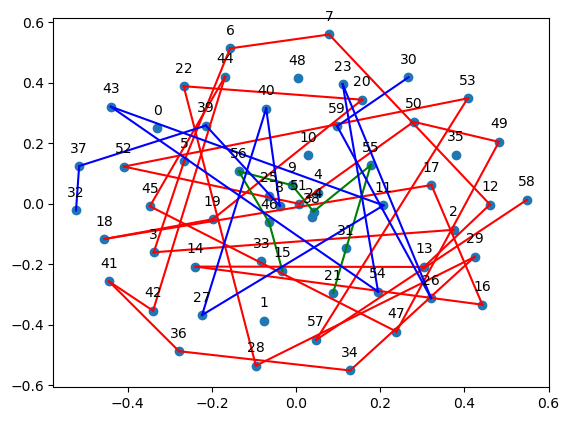

persistence =inf, finding: [1, 24]
 [[1, 21, 55, 24, 9, 56, 46, 15], [2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 29, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30]]
merging
[[1]]
[[1, 0]]
pbow:
[array([0., 4., 1., 1., 1.]), array([ 4.,  6.,  3., 11.,  5.]), array([3., 4., 5., 0., 0.])]
[[ 0.         11.83215957  5.19615242]
 [11.83215957  0.         12.4498996 ]
 [ 5.19615242 12.4498996   0.        ]]
score x0.85: [0.375] [0.4666666666666667] [0.6153846153846154] 
total score : 0.6333333333333333

[[1, 21, 55, 24, 9, 56, 46, 15], [2, 3, 5, 6, 7, 12, 13, 14, 16, 17, 18, 19, 20, 22, 28, 29, 34, 36, 41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 57, 58], [32, 37, 39, 8, 40, 27, 11, 43, 54, 23, 26, 59, 30]]


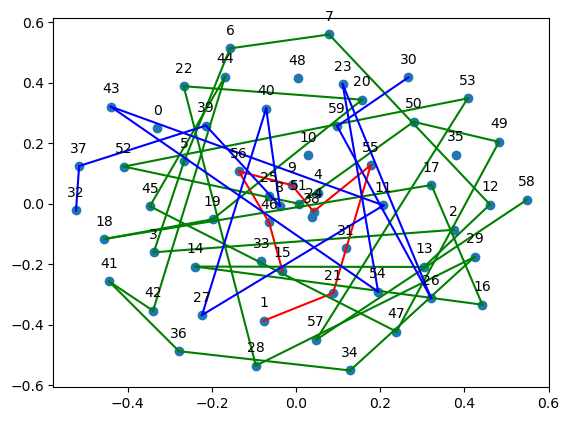

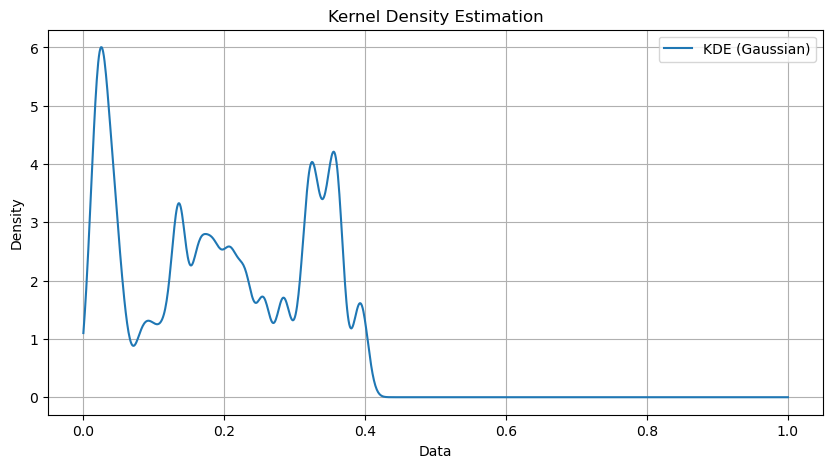

28 (60, 60)


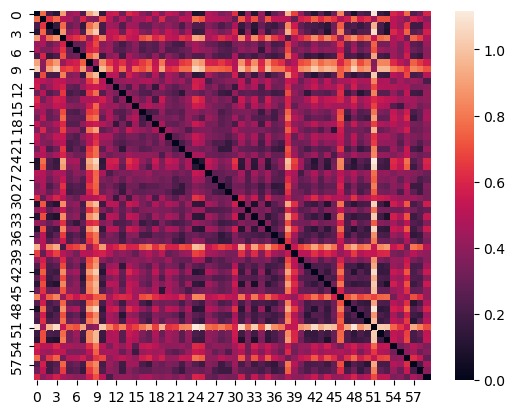

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


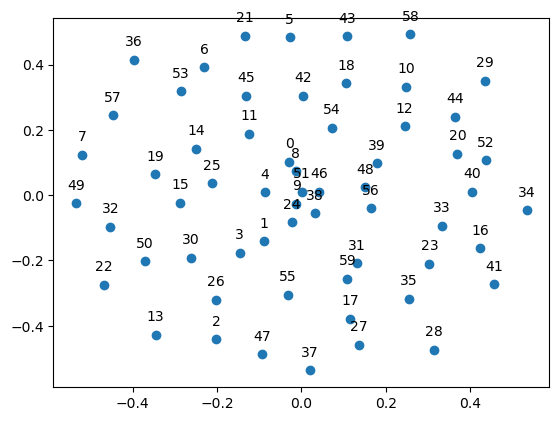

d 0 0 0.0 inf []
d 0 1 0.0 0.36546292720657725 [[20, 51]]
d 0 2 0.0 0.36204062561352757 [[14, 24]]
d 0 3 0.0 0.3549243633006456 [[24, 30]]
d 0 4 0.0 0.33755116294841536 [[21, 51]]
d 0 5 0.0 0.32591262272031474 [[18, 51]]
d 0 6 0.0 0.32011955473835263 [[24, 39]]
d 0 7 0.0 0.3170372124295785 [[12, 51]]
d 0 8 0.0 0.29140696444014746 [[9, 59]]
d 0 9 0.0 0.28695637535102847 [[6, 51]]
d 0 10 0.0 0.2674045472173344 [[29, 51]]
d 0 11 0.0 0.265004255216412 [[34, 51]]
d 0 12 0.0 0.2566899748717767 [[9, 55]]
d 0 13 0.0 0.2522864034563994 [[5, 51]]
d 0 14 0.0 0.24547526155482868 [[9, 15]]
d 0 15 0.0 0.2338977541135654 [[9, 27]]
d 0 16 0.0 0.22294997557797236 [[1, 24]]
d 0 17 0.0 0.22187898206453738 [[26, 51]]
d 0 18 0.0 0.2163602308287329 [[24, 56]]
d 0 19 0.0 0.20626966998007656 [[16, 51]]
d 0 20 0.0 0.1995905412566198 [[37, 51]]
d 0 21 0.0 0.19767023058239364 [[9, 32]]
d 0 22 0.0 0.19588446287650307 [[9, 54]]
d 0 23 0.0 0.1869421607007956 [[28, 51]]
d 0 24 0.0 0.1812484103793648 [[51, 58]]
d 0 2

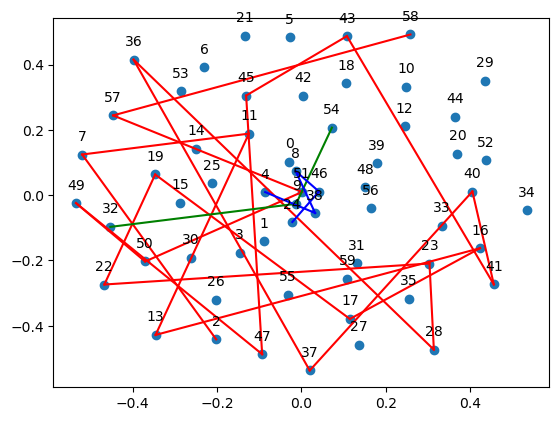

persistence =0.22187898206453738, finding: [24, 56]
 [[4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 9, 54]]
merging
[[56]]
[[2, 0]]
pbow:
[array([2., 2., 1.]), array([9., 5., 7.]), array([2., 0., 0.])]
[[ 0.          9.69535971  2.23606798]
 [ 9.69535971  0.         11.09053651]
 [ 2.23606798 11.09053651  0.        ]]
score x0.5166666666666667: [0.5] [0.5454545454545454] [0.6666666666666666] 
total score : 0.7666666666666666

[[4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 9, 54]]


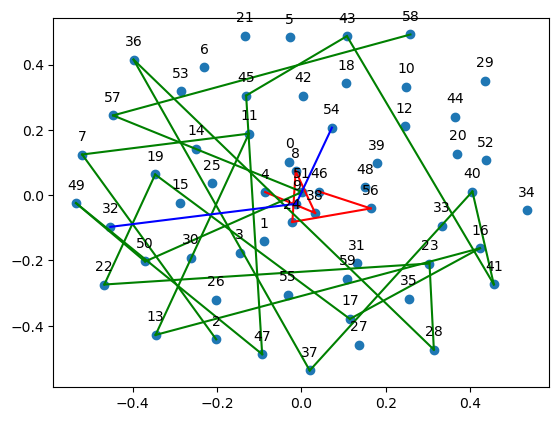

persistence =0.22294997557797236, finding: [26, 51]
 [[2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [4, 38, 8, 24, 56, 46], [32, 9, 54]]
merging
[[26]]
[[1, 0]]
pbow:
[array([ 7., 10.,  5.]), array([1., 2., 2.]), array([0., 2., 0.])]
[[ 0.         10.44030651 11.74734012]
 [10.44030651  0.          2.23606798]
 [11.74734012  2.23606798  0.        ]]
score x0.5333333333333333: [0.5217391304347826] [0.5] [0.6666666666666666] 
total score : 0.75

[[2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [4, 38, 8, 24, 56, 46], [32, 9, 54]]


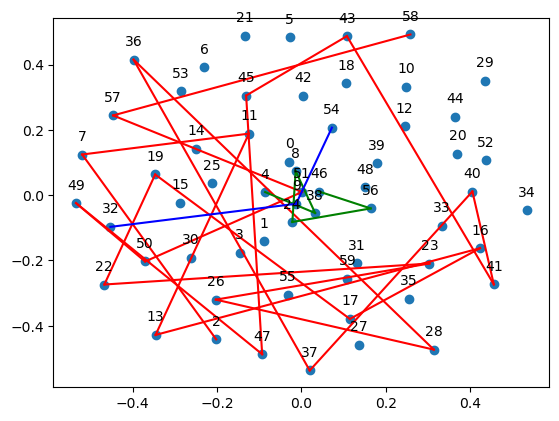

persistence =0.2338977541135654, finding: [1, 24]
 [[1, 4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 9, 54]]
merging
[[1]]
[[1, 0]]
pbow:
[array([2., 3., 1.]), array([8., 9., 5.]), array([2., 0., 0.])]
[[ 0.          9.38083152  3.16227766]
 [ 9.38083152  0.         11.91637529]
 [ 3.16227766 11.91637529  0.        ]]
score x0.55: [0.42857142857142855] [0.5217391304347826] [0.6666666666666666] 
total score : 0.75

[[1, 4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 9, 54]]


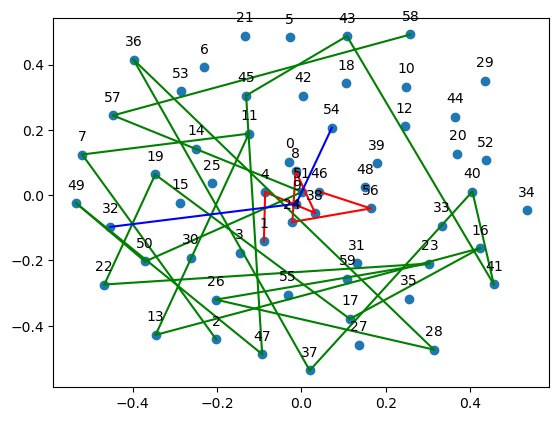

persistence =0.24547526155482868, finding: [9, 27]
 [[32, 9, 27, 54], [1, 4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58]]
merging
[[27]]
[[2, 0]]
pbow:
[array([0., 3., 0., 0.]), array([2., 2., 1., 1.]), array([6., 8., 4., 4.])]
[[0.         2.64575131 9.64365076]
 [2.64575131 0.         8.36660027]
 [9.64365076 8.36660027 0.        ]]
score x0.5666666666666667: [0.5] [0.42857142857142855] [0.5217391304347826] 
total score : 0.7333333333333334

[[32, 9, 27, 54], [1, 4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58]]


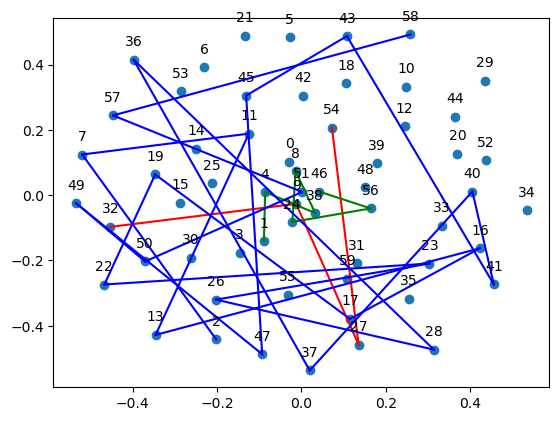

persistence =0.2522864034563994, finding: [9, 15]
 [[32, 9, 15, 54, 27], [1, 4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58]]
merging
[[15]]
[[0, 0]]
pbow:
[array([0., 2., 0., 2., 0.]), array([2., 1., 1., 2., 0.]), array([6., 7., 3., 2., 4.])]
[[0.         2.44948974 9.2736185 ]
 [2.44948974 0.         8.48528137]
 [9.2736185  8.48528137 0.        ]]
score x0.5833333333333334: [0.4] [0.42857142857142855] [0.5217391304347826] 
total score : 0.7333333333333334

[[32, 9, 15, 54, 27], [1, 4, 38, 8, 24, 56, 46], [2, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58]]


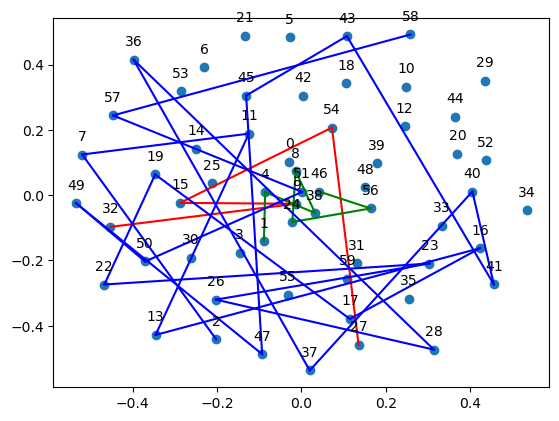

persistence =0.2566899748717767, finding: [5, 51]
 [[2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 9, 15, 54, 27], [1, 4, 38, 8, 24, 56, 46]]
merging
[[5]]
[[2, 0]]
pbow:
[array([7., 4., 6., 2., 4.]), array([2., 0., 0., 2., 0.]), array([0., 1., 2., 2., 1.])]
[[0.         9.64365076 9.11043358]
 [9.64365076 0.         3.16227766]
 [9.11043358 3.16227766 0.        ]]
score x0.6: [0.5] [0.4] [0.42857142857142855] 
total score : 0.7166666666666667

[[2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 9, 15, 54, 27], [1, 4, 38, 8, 24, 56, 46]]


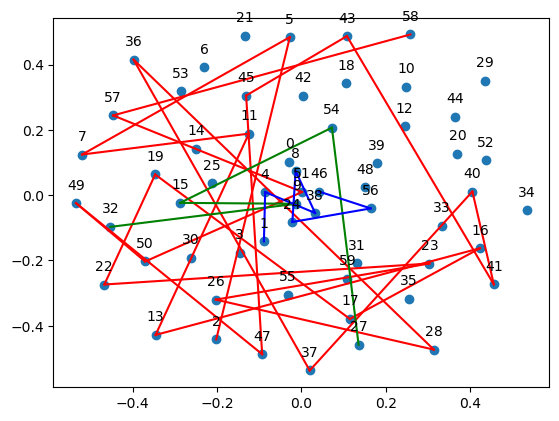

persistence =0.265004255216412, finding: [9, 55]
 [[32, 54, 55, 9, 27, 15], [2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 8, 24, 56, 46]]
merging
[[55]]
[[1, 0]]
pbow:
[array([0., 0., 0., 3., 2.]), array([4., 6., 4., 2., 7.]), array([1., 2., 1., 2., 0.])]
[[0.         9.69535971 3.31662479]
 [9.69535971 0.         9.11043358]
 [3.31662479 9.11043358 0.        ]]
score x0.6166666666666667: [0.5] [0.5] [0.42857142857142855] 
total score : 0.7

[[32, 54, 55, 9, 27, 15], [2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 8, 24, 56, 46]]


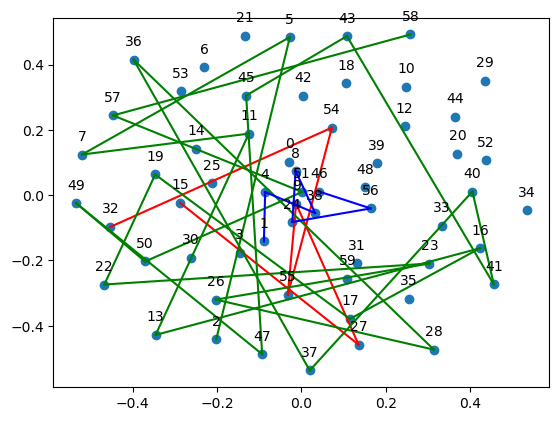

persistence =0.2674045472173344, finding: [34, 51]
 [[2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 9, 27, 15], [1, 4, 38, 8, 24, 56, 46]]
merging
[[34]]
[[1, 0]]
pbow:
[array([3., 4., 8., 5., 4.]), array([3., 0., 2., 0., 0.]), array([2., 1., 1., 2., 0.])]
[[0.         9.64365076 9.16515139]
 [9.64365076 0.         2.64575131]
 [9.16515139 2.64575131 0.        ]]
score x0.6333333333333333: [0.52] [0.5] [0.42857142857142855] 
total score : 0.7

[[2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 9, 27, 15], [1, 4, 38, 8, 24, 56, 46]]


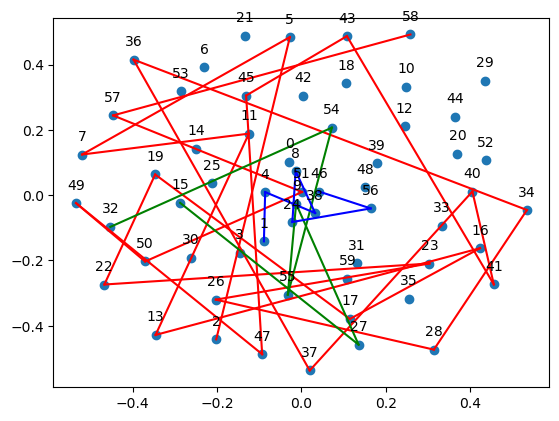

persistence =0.28695637535102847, finding: [29, 51]
 [[2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 9, 27, 15], [1, 4, 38, 8, 24, 56, 46]]
merging
[[29]]
[[0, 0]]
pbow:
[array([6., 8., 4., 3., 4.]), array([0., 2., 3., 0., 0.]), array([2., 1., 2., 1., 0.])]
[[0.         9.89949494 9.43398113]
 [9.89949494 0.         2.64575131]
 [9.43398113 2.64575131 0.        ]]
score x0.65: [0.5] [0.5] [0.42857142857142855] 
total score : 0.6833333333333333

[[2, 5, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 9, 27, 15], [1, 4, 38, 8, 24, 56, 46]]


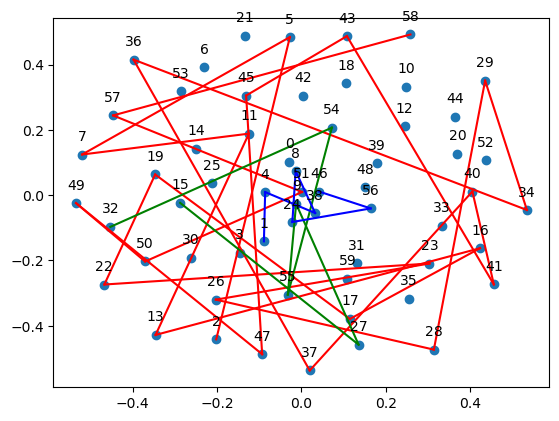

persistence =0.29140696444014746, finding: [6, 51]
 [[2, 5, 6, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 9, 27, 15], [1, 4, 38, 8, 24, 56, 46]]
merging
[[6]]
[[0, 0]]
pbow:
[array([4., 8., 4., 4., 6.]), array([0., 2., 0., 3., 0.]), array([1., 2., 1., 0., 2.])]
[[ 0.         10.24695077  9.2736185 ]
 [10.24695077  0.          3.87298335]
 [ 9.2736185   3.87298335  0.        ]]
score x0.6666666666666666: [0.48148148148148145] [0.5] [0.42857142857142855] 
total score : 0.6833333333333333

[[2, 5, 6, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 9, 27, 15], [1, 4, 38, 8, 24, 56, 46]]


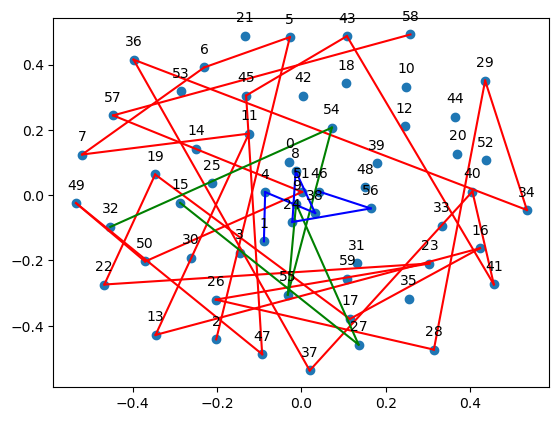

persistence =0.3170372124295785, finding: [9, 59]
 [[32, 54, 55, 27, 9, 59, 15], [2, 5, 6, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 8, 24, 56, 46]]
merging
[[59]]
[[1, 0]]
pbow:
[array([0., 4., 0., 2., 0.]), array([4., 4., 3., 8., 7.]), array([1., 0., 1., 2., 2.])]
[[ 0.         10.48808848  4.69041576]
 [10.48808848  0.          9.48683298]
 [ 4.69041576  9.48683298  0.        ]]
score x0.6833333333333333: [0.5714285714285714] [0.48148148148148145] [0.42857142857142855] 
total score : 0.6833333333333333

[[32, 54, 55, 27, 9, 59, 15], [2, 5, 6, 7, 11, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 8, 24, 56, 46]]


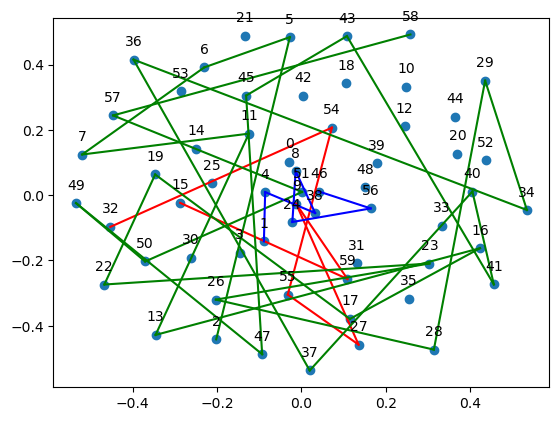

persistence =0.32011955473835263, finding: [12, 51]
 [[2, 5, 6, 7, 11, 12, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15], [1, 4, 38, 8, 24, 56, 46]]
merging
[[12]]
[[1, 0]]
pbow:
[array([8., 4., 5., 4., 6.]), array([2., 0., 4., 0., 0.]), array([2., 1., 0., 1., 2.])]
[[ 0.         10.24695077  9.74679434]
 [10.24695077  0.          4.69041576]
 [ 9.74679434  4.69041576  0.        ]]
score x0.7: [0.4642857142857143] [0.5714285714285714] [0.42857142857142855] 
total score : 0.6833333333333333

[[2, 5, 6, 7, 11, 12, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15], [1, 4, 38, 8, 24, 56, 46]]


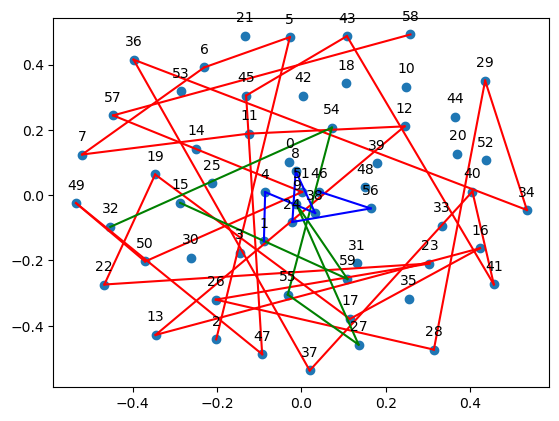

persistence =0.32591262272031474, finding: [24, 39]
 [[1, 4, 38, 39, 8, 24, 56, 46], [2, 5, 6, 7, 11, 12, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15]]
merging
[[39]]
[[2, 0]]
pbow:
[array([1., 2., 1., 1., 2.]), array([9., 5., 7., 2., 4.]), array([2., 0., 0., 1., 3.])]
[[ 0.         10.67707825  2.64575131]
 [10.67707825  0.         11.18033989]
 [ 2.64575131 11.18033989  0.        ]]
score x0.7166666666666667: [0.5] [0.4642857142857143] [0.5714285714285714] 
total score : 0.6666666666666667

[[1, 4, 38, 39, 8, 24, 56, 46], [2, 5, 6, 7, 11, 12, 13, 16, 17, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15]]


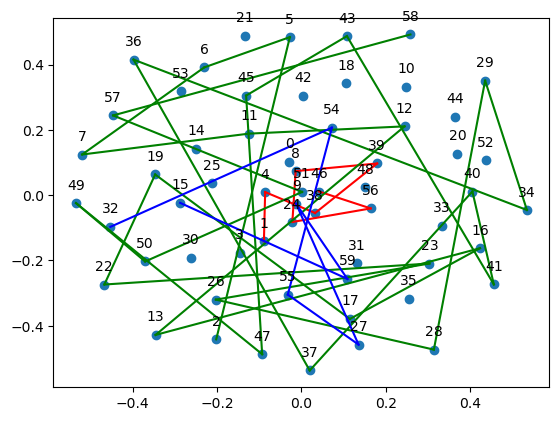

persistence =0.33755116294841536, finding: [18, 51]
 [[2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 39, 8, 24, 56, 46], [32, 54, 55, 27, 9, 59, 15]]
merging
[[18]]
[[1, 0]]
pbow:
[array([7., 4., 9., 5., 3.]), array([1., 2., 1., 2., 1.]), array([0., 3., 2., 0., 1.])]
[[ 0.         10.81665383 11.3137085 ]
 [10.81665383  0.          2.64575131]
 [11.3137085   2.64575131  0.        ]]
score x0.7333333333333333: [0.4482758620689655] [0.5] [0.5714285714285714] 
total score : 0.6666666666666667

[[2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 39, 8, 24, 56, 46], [32, 54, 55, 27, 9, 59, 15]]


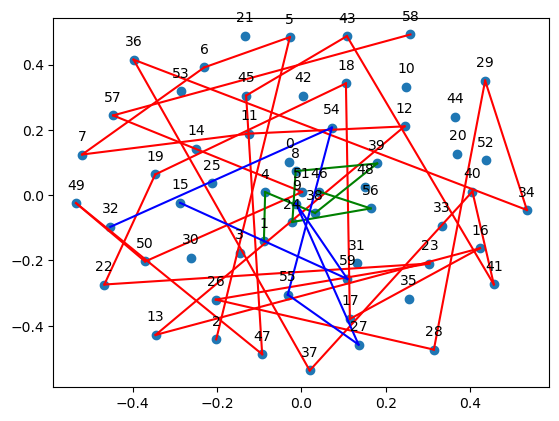

persistence =0.3549243633006456, finding: [21, 51]
 [[2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 39, 8, 24, 56, 46], [32, 54, 55, 27, 9, 59, 15]]
merging
[[21]]
[[0, 0]]
pbow:
[array([4., 7., 9., 5., 4.]), array([1., 1., 1., 2., 2.]), array([1., 0., 2., 0., 3.])]
[[ 0.         11.04536102 11.53256259]
 [11.04536102  0.          2.64575131]
 [11.53256259  2.64575131  0.        ]]
score x0.75: [0.43333333333333335] [0.5] [0.5714285714285714] 
total score : 0.6666666666666667

[[2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 39, 8, 24, 56, 46], [32, 54, 55, 27, 9, 59, 15]]


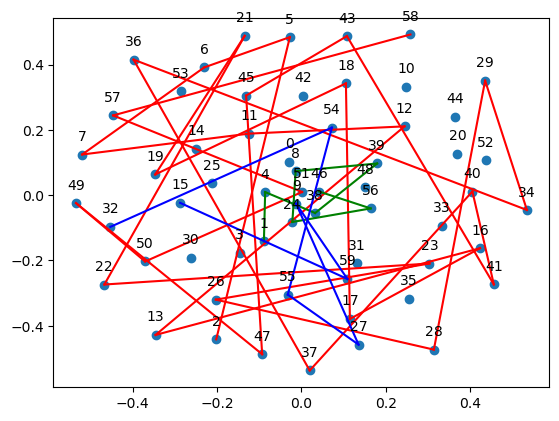

persistence =0.36204062561352757, finding: [24, 30]
 [[1, 4, 38, 39, 8, 46, 24, 56, 30], [2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15]]
merging
[[30]]
[[1, 0]]
pbow:
[array([2., 1., 1., 2., 2.]), array([4., 7., 9., 4., 5.]), array([3., 0., 2., 1., 0.])]
[[ 0.         10.81665383  2.82842712]
 [10.81665383  0.         11.53256259]
 [ 2.82842712 11.53256259  0.        ]]
score x0.7666666666666667: [0.5555555555555556] [0.43333333333333335] [0.5714285714285714] 
total score : 0.6666666666666667

[[1, 4, 38, 39, 8, 46, 24, 56, 30], [2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15]]


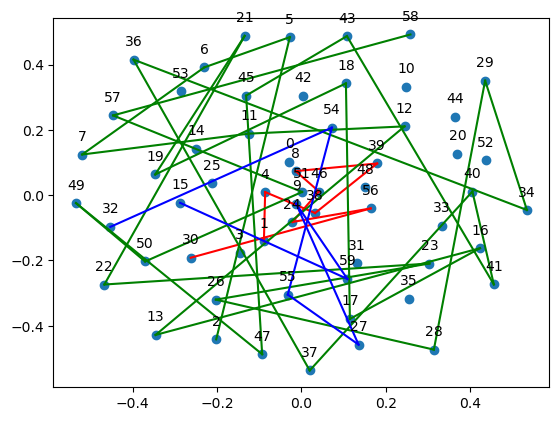

persistence =0.36546292720657725, finding: [14, 24]
 [[1, 4, 38, 39, 8, 14, 46, 24, 56, 30], [2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15]]
merging
[[14]]
[[0, 0]]
pbow:
[array([3., 3., 3., 0., 0.]), array([8., 9., 3., 4., 5.]), array([2., 0., 0., 4., 0.])]
[[ 0.         10.09950494  5.91607978]
 [10.09950494  0.         12.28820573]
 [ 5.91607978 12.28820573  0.        ]]
score x0.7833333333333333: [0.5] [0.43333333333333335] [0.5714285714285714] 
total score : 0.65

[[1, 4, 38, 39, 8, 14, 46, 24, 56, 30], [2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [32, 54, 55, 27, 9, 59, 15]]


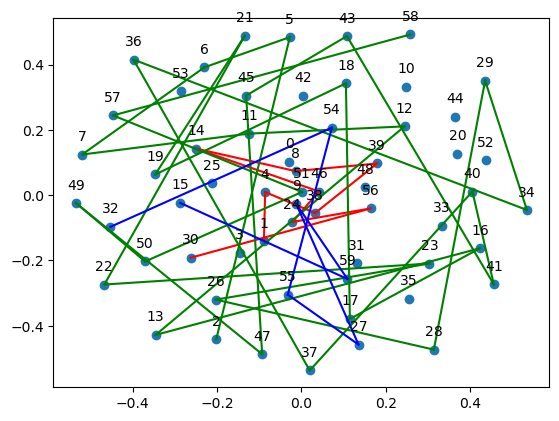

persistence =inf, finding: [20, 51]
 [[2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 39, 8, 14, 46, 24, 56, 30], [32, 54, 55, 27, 9, 59, 15]]
merging
[[20]]
[[1, 0]]
pbow:
[array([4., 9., 8., 4., 5.]), array([3., 3., 3., 0., 0.]), array([0., 0., 2., 4., 0.])]
[[ 0.         10.14889157 12.56980509]
 [10.14889157  0.          5.91607978]
 [12.56980509  5.91607978  0.        ]]
score x0.8: [0.41935483870967744] [0.5] [0.5714285714285714] 
total score : 0.65

[[2, 5, 6, 7, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 28, 29, 34, 36, 37, 40, 41, 43, 45, 47, 49, 50, 51, 57, 58], [1, 4, 38, 39, 8, 14, 46, 24, 56, 30], [32, 54, 55, 27, 9, 59, 15]]


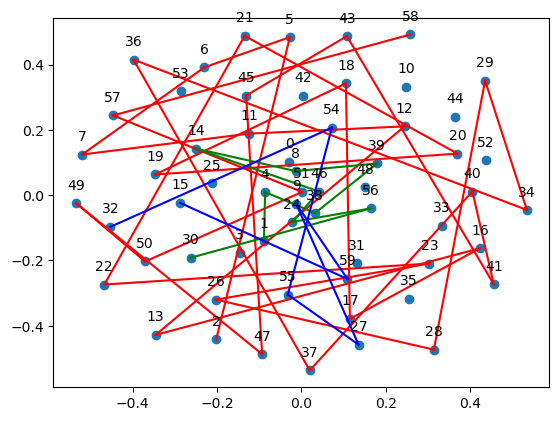

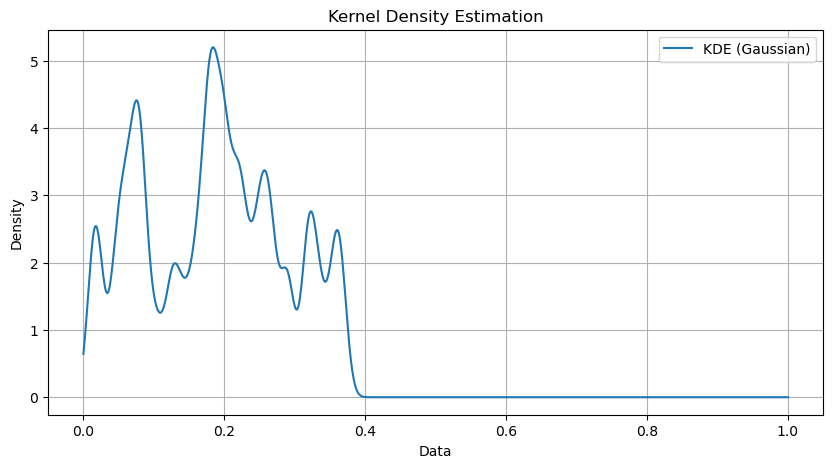

26 (60, 60)


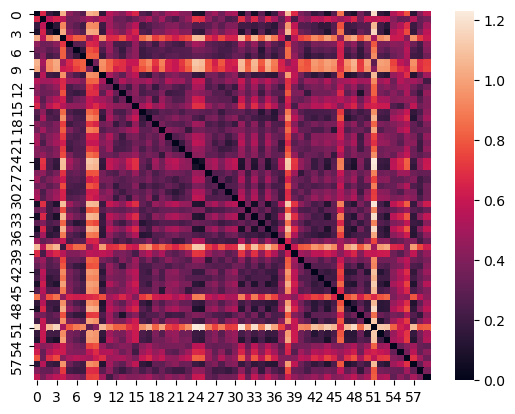

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


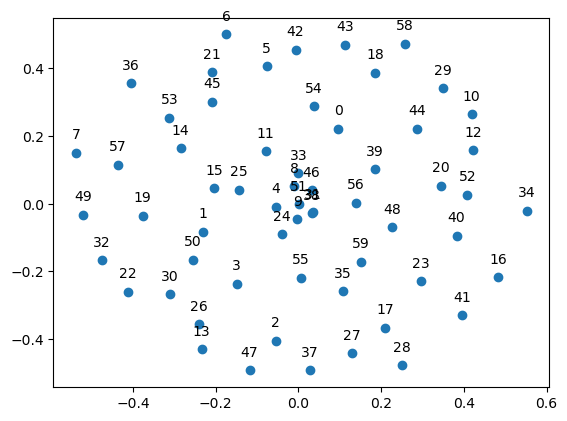

d 0 0 0.0 inf []
d 0 1 0.0 0.3247272409023182 [[9, 55]]
d 0 2 0.0 0.3054125034655364 [[21, 51]]
d 0 3 0.0 0.30308222154265785 [[15, 24]]
d 0 4 0.0 0.29513680645644547 [[14, 51]]
d 0 5 0.0 0.2926378068989255 [[1, 24]]
d 0 6 0.0 0.28395573677445196 [[24, 39]]
d 0 7 0.0 0.2780762872281394 [[29, 51]]
d 0 8 0.0 0.26589733195541243 [[30, 51]]
d 0 9 0.0 0.25105437715312695 [[27, 51]]
d 0 10 0.0 0.2501347004092559 [[37, 51]]
d 0 11 0.0 0.2495658942109492 [[20, 51]]
d 0 12 0.0 0.2028986731390795 [[51, 58]]
d 0 13 0.0 0.200985069486614 [[5, 51]]
d 0 14 0.0 0.1825219135784707 [[51, 59]]
d 0 15 0.0 0.18107124149343612 [[51, 54]]
d 0 16 0.0 0.1800969528882137 [[13, 51]]
d 0 17 0.0 0.17917819182562134 [[12, 51]]
d 0 18 0.0 0.17847725273139126 [[24, 56]]
d 0 19 0.0 0.17574975849522556 [[22, 51]]
d 0 20 0.0 0.17213713296607946 [[18, 51]]
d 0 21 0.0 0.14404564535612718 [[49, 51]]
d 0 22 0.0 0.11195598523013872 [[6, 51]]
d 0 23 0.0 0.10336946613015763 [[28, 51]]
d 0 24 0.0 0.09412087833380023 [[31, 46]]

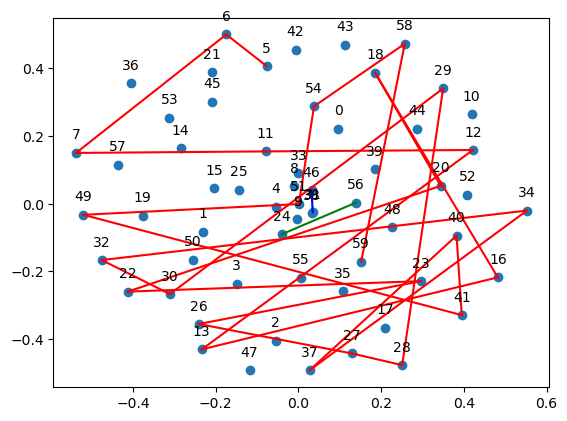

persistence =0.2926378068989255, finding: [24, 39]
 [[24, 56, 39], [5, 6, 7, 11, 12, 13, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [31, 46]]
merging
[[39]]
[[1, 0]]
pbow:
[array([2., 0.]), array([13., 12.]), array([0., 1.])]
[[ 0.         16.2788206   2.23606798]
 [16.2788206   0.         17.02938637]
 [ 2.23606798 17.02938637  0.        ]]
score x0.5166666666666667: [0.6666666666666666] [0.4230769230769231] [1.0] 
total score : 0.8

[[24, 56, 39], [5, 6, 7, 11, 12, 13, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [31, 46]]


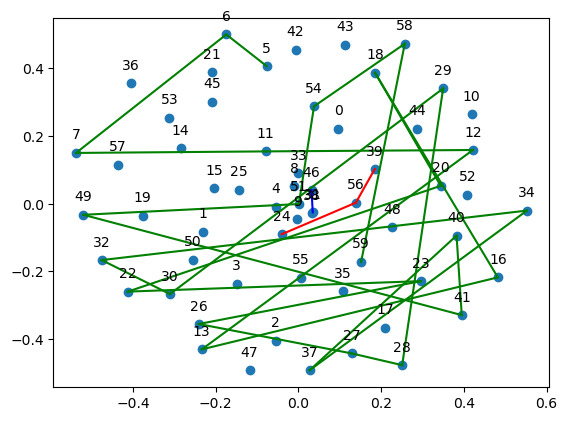

persistence =0.29513680645644547, finding: [1, 24]
 [[24, 1, 56, 39], [5, 6, 7, 11, 12, 13, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [31, 46]]
merging
[[1]]
[[0, 0]]
pbow:
[array([0., 3.]), array([12., 13.]), array([1., 0.])]
[[ 0.         15.62049935  3.16227766]
 [15.62049935  0.         17.02938637]
 [ 3.16227766 17.02938637  0.        ]]
score x0.5333333333333333: [0.5] [0.4230769230769231] [1.0] 
total score : 0.7833333333333333

[[24, 1, 56, 39], [5, 6, 7, 11, 12, 13, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [31, 46]]


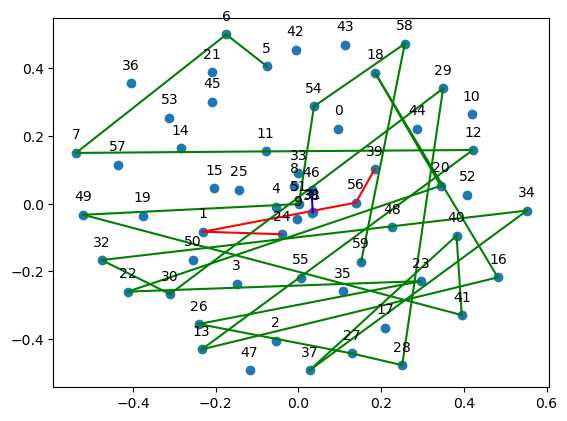

persistence =0.30308222154265785, finding: [14, 51]
 [[5, 6, 7, 11, 12, 13, 14, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [24, 1, 56, 39], [31, 46]]
merging
[[14]]
[[1, 0]]
pbow:
[array([12., 14.]), array([0., 3.]), array([1., 0.])]
[[ 0.         16.2788206  17.80449381]
 [16.2788206   0.          3.16227766]
 [17.80449381  3.16227766  0.        ]]
score x0.55: [0.4074074074074074] [0.5] [1.0] 
total score : 0.7833333333333333

[[5, 6, 7, 11, 12, 13, 14, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [24, 1, 56, 39], [31, 46]]


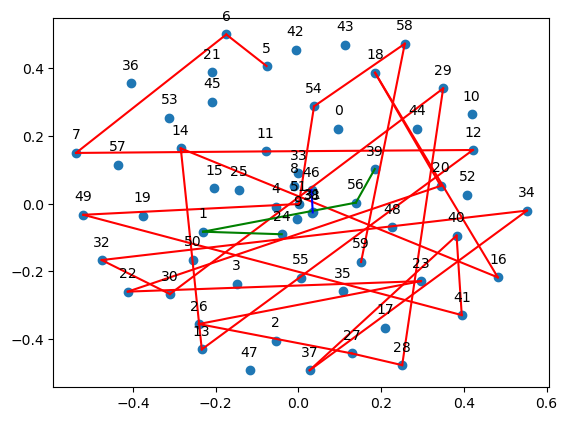

persistence =0.3054125034655364, finding: [15, 24]
 [[1, 39, 15, 24, 56], [5, 6, 7, 11, 12, 13, 14, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [31, 46]]
merging
[[15]]
[[1, 0]]
pbow:
[array([0., 4.]), array([12., 14.]), array([1., 0.])]
[[ 0.         15.62049935  4.12310563]
 [15.62049935  0.         17.80449381]
 [ 4.12310563 17.80449381  0.        ]]
score x0.5666666666666667: [0.4] [0.4074074074074074] [1.0] 
total score : 0.7833333333333333

[[1, 39, 15, 24, 56], [5, 6, 7, 11, 12, 13, 14, 16, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [31, 46]]


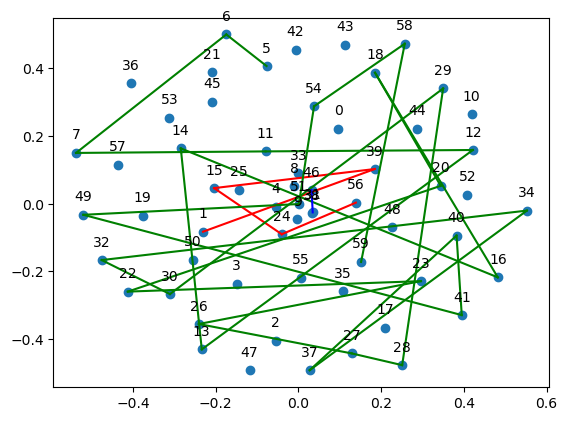

persistence =0.3247272409023182, finding: [21, 51]
 [[5, 6, 7, 11, 12, 13, 14, 16, 18, 20, 21, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [1, 39, 15, 24, 56], [31, 46]]
merging
[[21]]
[[1, 0]]
pbow:
[array([12., 15.]), array([0., 4.]), array([1., 0.])]
[[ 0.         16.2788206  18.60107524]
 [16.2788206   0.          4.12310563]
 [18.60107524  4.12310563  0.        ]]
score x0.5833333333333334: [0.39285714285714285] [0.4] [1.0] 
total score : 0.7833333333333333

[[5, 6, 7, 11, 12, 13, 14, 16, 18, 20, 21, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [1, 39, 15, 24, 56], [31, 46]]


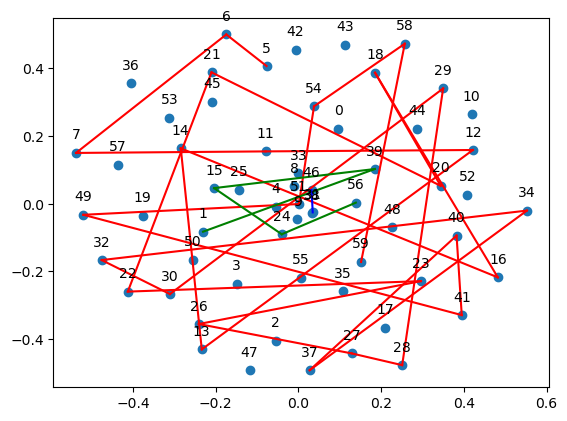

persistence =inf, finding: [9, 55]
 [[9, 55], [5, 6, 7, 11, 12, 13, 14, 16, 18, 20, 21, 22, 23, 26, 27, 28, 29, 30, 32, 34, 37, 40, 41, 49, 51, 54, 58, 59], [1, 39, 15, 24, 56], [31, 46]]
merging
[]
[]
pbow:
[array([1., 0.]), array([15., 12.]), array([4., 0.]), array([0., 1.])]
[[ 0.         18.43908891  3.          1.41421356]
 [18.43908891  0.         16.2788206  18.60107524]
 [ 3.         16.2788206   0.          4.12310563]
 [ 1.41421356 18.60107524  4.12310563  0.        ]]
score x0.6166666666666667: [0.5] [0.39285714285714285] [0.4] [1.0] 
total score : 0.7666666666666666



IndexError: list index out of range

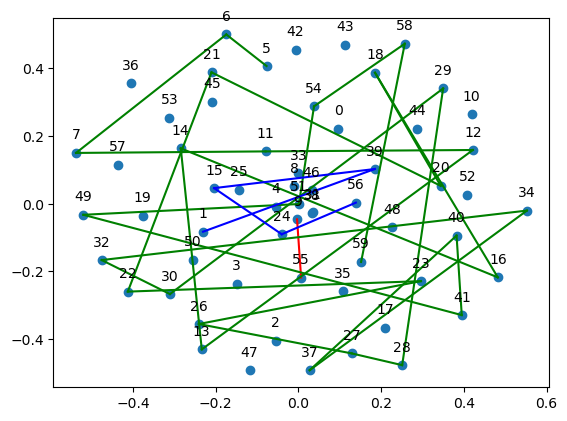

In [7]:
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    
    count = 0
    results = []
    dv_seq = []

    for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
        tolerance = 1e-6
        birth_simplices = []
        death_simplices = []
        filtration = simplex_tree.get_filtration()

        for simplex, filtration_value in filtration:
            # print(filtration_value, birth_value)
            if abs(filtration_value - birth_value) < tolerance:
                # print(simplex)
                birth_simplices.append(simplex)
            elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                death_simplices.append(simplex)
                
        involved_points_d = (mergeSublistsWithSharedItems(death_simplices))

        if len(involved_points_d) >= 0 : 
            print('d', d, count, birth_value, death_value, involved_points_d) 
            results.append([death_value, involved_points_d])
            dv_seq.append(death_value)
        count += 1
    print("the gaps:")
    print(findLargestGaps(dv_seq, 3))
    
    a = []
    for [death_value, concern_points] in results:
        for c in concern_points:
            # print(c)
            a.append(c)
            
    print(a)
    last_merged = None
    last_distance = None
    score = 0
    has_draw = False
    for i in range(min(len(a)-1, len(results)-1), -1, -1):
        warn_flag = False
        f = flatten(a[i:len(a)])
        if (np.unique(f).shape[0] == total_nums):
            continue
        merged = mergeSublistsWithSharedItems(a[i:len(a)])
        print(f"persistence ={results[i][0]}, finding: {a[i]}\n", merged)
        # print(merged, last_merged)
        score = getTotalLength(merged)/normal_nums/2

        newly_merged = []
        newly_added = []
        merging = []

        if (last_merged != None and len(last_merged)):
            print("merging")
            for idxa, list_a in enumerate(last_merged):
                for idxb, list_b in enumerate(merged):
                    # print(list_a, list_b)
                    if (isProperSuperset(list_a, list_b)):
                        newly_merged.append([idxa, idxb])
                        newly_added.append(findDifferentElements(list_a, list_b))
        
            print(newly_added)
            print(newly_merged)

            if (len(newly_merged) >= 2):
                merging = list(set(newly_merged[0] + newly_merged[1]))
                # merging = find_different_elements(newly_merged[0], newly_merged[1])
                print(merging)
                # print(last_distance)
                if(len(merging) and last_distance.shape[0] > max(merging[-1], merging[-2])):
                    print("merging with pbow_d: ",last_distance[merging[-1]][merging[-2]], np.max(last_distance))
                    if (last_distance[merging[-1]][merging[-2]] >= np.max(last_distance)/2 and score > 0.6 ):
                        print("warn")
                        warn_flag = True
                        a[i] = [0, 0]
                        merged = copy.deepcopy(last_merged)

        
        last_merged = copy.deepcopy(merged)


        
        sub_pers = []
        min_length = float('Inf')
        for sub_points in merged:
            if (len(sub_points) <= 1):
                continue
            min_length = min(min_length, len(sub_points))
            sub_diagram = gd.RipsComplex(distance_matrix=np.array(data)[sub_points][:,sub_points], max_edge_length=100)
            sub_simplex_tree = sub_diagram.create_simplex_tree(max_dimension=2)
            sub_persistence = sub_simplex_tree.persistence()
            sub_pd = np.array([[b, d] for dim, (b, d) in sub_persistence if (dim == 0) and (d != float('inf'))])
            sub_pers.append(sub_pd)

        if (len(sub_pers) > 1 and min_length > 1):
            pbow = perscode.PBoW(N = min(5, min_length), normalize = False)
            pbow_diagrams  = pbow.transform(sub_pers)
            print("pbow:")
            print(pbow_diagrams)
            pbow_distance = np.zeros((len(pbow_diagrams),len(pbow_diagrams)))
            for k in range(len(pbow_diagrams)):
                for j in range(len(pbow_diagrams)):
                    pbow_distance[k][j] = np.linalg.norm(pbow_diagrams[k] - pbow_diagrams[j])
            print(pbow_distance)
        
            if (not warn_flag):
                last_distance = copy.deepcopy(pbow_distance)

        print(f"score x{score}: ",end='')
        total_errors = 0
        for j in merged:
            print([np.mean(np.array(j) >= normal_nums)], end=' ')
            total_errors += min(np.sum((np.array(j) >= normal_nums) == 0),np.sum((np.array(j) >= normal_nums) == 1))
        print(f"\ntotal score : {1- total_errors/data.shape[0]}")
        print()

        if (score >= 0.5 and len(merged) > 1):
            plt.clf()
            plt.scatter(mds_results[:, 0], mds_results[:, 1])
            for idx, points in enumerate(mds_results):
                plt.annotate(idx, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')

            # print(merged)
            draw_point_set = copy.deepcopy(merged)
            colors = ['r', 'g', 'b']
            for color, layer in enumerate(merged):
                # print(layer)
                for p in range(len(layer)-1):
                    p1 = mds_results[layer[p]]
                    p2 = mds_results[layer[p + 1]]
                    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], colors[color]+'-')
            has_draw = True
            print(draw_point_set)
            plt.show()

    if (has_draw):
        pass

    group = np.zeros((total_nums,total_nums))
    for i in mergeSublistsWithSharedItems(a)[0]:
        group[i][i] = 1

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()
